# **Data Science Weekly - Conversion rate challenge**

Link to Google Collab notebook: https://colab.research.google.com/drive/1n1MrT0vhJf1kBOgBWFmOmPVVjs8XyjBA?usp=sharing

## **Company's Description** 📇
www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !

## **Project** 🚧
The data scientists who created the newsletter would like to understand better the behaviour of the users visiting their website. They would like to know if it's possible to build a model that predicts if a given user will subscribe to the newsletter, by using just a few information about the user. They would like to analyze the parameters of the model to highlight features that are important to explain the behaviour of the users, and maybe discover a new lever for action to improve the newsletter's conversion rate.

They designed a competition aiming at building a model that allows to predict the conversions (i.e. when a user will subscribe to the newsletter). To do so, they open-sourced a dataset containing some data about the traffic on their website. To assess the rankings of the different competing teams, they decided to use the f1-score.

# Imports

In [ ]:
# Basic data manipulation
import pandas as pd
import numpy as np
import itertools

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE


# Import ensemble methods
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from xgboost import XGBClassifier

# Visualizations tools
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

In [ ]:
# Dataset import
df = pd.read_csv('conversion_data_train.csv')
print('Dataset with labels:', df.shape)

Dataset with labels: (284580, 6)


In [ ]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Dataset Exploration

In [ ]:
# Basic statistics
df.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [ ]:
# Missing values -> none
df.isna().sum()

,0
country,0
age,0
new_user,0
source,0
total_pages_visited,0
converted,0


In [ ]:
# Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [ ]:
# Label distribution -> imbalanced
df['converted'].value_counts()

,count
converted,
0,275400
1,9180


## **Data Visualizations**

In [ ]:
# The dataset is quite big : let's first create a sample of the dataset before making any visualizations !

df_sample = df.sample(10000)

In [ ]:
# Visualize pairwise dependencies between variables

fig = px.scatter_matrix(df_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False,
            autosize=False, height=800, width = 800)
fig.show()

**Key observations:**

- There appears to be a linear relationship between age and total pages visited.
- Users who convert appear to be younger that those who don't.
- They also appear to visit more pages in total.

In [ ]:
# Univariate variables distributions

num_features = ['age', 'new_user', 'total_pages_visited', 'converted']
for i in range(len(num_features)):
    fig = px.histogram(df_sample[num_features[i]], height=300, width=500)
    fig.show()

**Key observations:**:

- The data appear to be skewed and imbalanced:

-> 'age' and 'total_pages_visited' values are skewed to the right

-> Many more new users that already existing ones

-> Target converted is largely imbalanced

In [ ]:
# Distribution of countries -> Majority US

df_sample['country'].value_counts()

,count
country,
US,5732
China,2400
UK,1454
Germany,414


In [ ]:
# Visualizations of categorical variables

cat_features = ['country', 'source']

for feature in cat_features:
    fig = px.bar(df_sample, x=df_sample[feature].value_counts().index,
                 y=df_sample[feature].value_counts().values,
                 labels={'x': feature, 'y': 'Count'},
                 height=300, width=500)
    fig.show()

In [ ]:
# Correlation matrix

numeric_df = df_sample.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr().round(2)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())

fig.show()

**Key observations:**

- The total number of pages visited is most correlated with conversion rate (0.51), followed by being a new user (-0.14).
- Remaining numeric variables are not correlated with each other.

# Machine Learning models

## **Basic Preprocessing Steps**

In [ ]:
df.dtypes

,0
country,object
age,int64
new_user,int64
source,object
total_pages_visited,int64
converted,int64


In [ ]:
# Convert 'new_user' as object type to consider it as categoric features in the model (vs numeric)

df['new_user'] = df['new_user'].astype(object)

In [ ]:
# Divide dataset into features X and target Y

target_variable = 'converted'

X = df.drop(target_variable, axis=1)
Y = df.loc[:, target_variable]

In [ ]:
## Pre-processing

# Divide dataset Train set & Test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y #stratified split to preserves class proportions of y in both the train and test sets.
    )

# Automatically detect names of numeric/categorical columns
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=object).columns.tolist()

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessings
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


## Function for model performance comparison

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold

results = []

def evaluate_model(name, model, X_train, y_train, X_test, y_test,
                   cv=5, threshold=None, random_state=42):
    """
    Binary classification evaluator (positive class = 1).
    - Reports: F1_train, F1_test, overfit_gap, CV mean/std (F1).
    - If `threshold` is set (e.g., 0.35) and the model supports predict_proba,
      predictions use that threshold on P(y=1).
    """

    # Fit
    model.fit(X_train, y_train)

    # Helper: prediction with optional threshold
    def _predict_with_threshold(m, X):
        if threshold is not None and hasattr(m, "predict_proba"):
            pos_idx = np.where(m.classes_ == 1)[0][0]
            p = m.predict_proba(X)[:, pos_idx]
            return (p >= float(threshold)).astype(int)
        return m.predict(X)

    # Predictions
    ytr = _predict_with_threshold(model, X_train)
    yte = _predict_with_threshold(model, X_test)

    # Metrics (binary F1 on class 1)
    f1_tr = f1_score(y_train, ytr)
    f1_te = f1_score(y_test,  yte)

    row = {
        "model": name,
        "f1_train": f1_tr,
        "f1_test":  f1_te,
    }

    # Stratified CV on TRAIN only
    if cv:
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        scorer = make_scorer(f1_score)  # binary F1 with positive class = 1
        scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=scorer)
        row["cv_mean_f1"] = scores.mean()
        row["cv_std"] = scores.std()

    results.append(row)


In [ ]:
results = []  # reset

evaluate_model("LogReg (balanced)",
               LogisticRegression(max_iter=1000, class_weight="balanced"),
               X_train, y_train, X_test, y_test, cv=5)

evaluate_model("LogReg (thr=0.35)",
               LogisticRegression(max_iter=1000, class_weight="balanced"),
               X_train, y_train, X_test, y_test, cv=5, threshold=0.35)

evaluate_model("RandomForest",
               RandomForestClassifier(n_estimators=300, random_state=42),
               X_train, y_train, X_test, y_test, cv=5)

results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)

## **Multivariate Logistic regression**

In [ ]:
# Train logistic model
log_classifier = LogisticRegression()
log_classifier.fit(X_train, Y_train)

# Predictions on training and test sets
Y_train_pred = log_classifier.predict(X_train)
Y_test_pred = log_classifier.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7660311958405546
f1-score on test set :  0.7546030787805614


In [ ]:
# Cross-validated scores

# Check the average f-1 score with a cross-validation (here using K=10)
scores = cross_val_score(log_classifier, X_train, Y_train, scoring="f1", cv=10)

print("cross-validated f1-score : ", scores.mean())
print("standard deviation : ", scores.std())

cross-validated f1-score :  0.7657129780631768
standard deviation :  0.008581199678739547


In [ ]:
results = []

evaluate_model("LogReg (baseline)",
               log_classifier,
               X_train, Y_train, X_test, Y_test, cv=10)

results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)

,model,f1_train,f1_test,cv_mean_f1,cv_std
0,LogReg (baseline),0.766031,0.754603,0.76576,0.012338


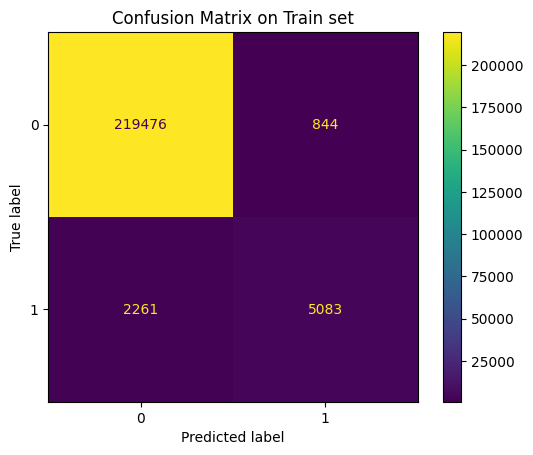

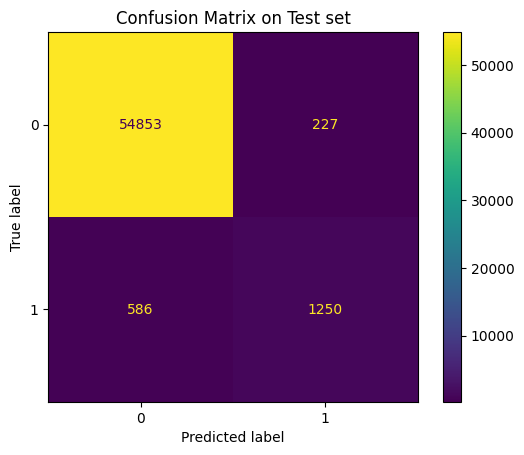

In [ ]:
# Visualize confusion matrices

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(log_classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(log_classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()


**Key insights:**

- The logistic regression model is very good at recognizing class 0 (non-conversion), as we have few false positives (227)
- The model catches 68% of converted cases, but misses about 32% (586 false negatives)


Try balancing the classes by giving higher weight to the minority class (here Y=0). This makes the scores drop significantly .

In [ ]:
# Train logistic model
log_classifier_balanced = LogisticRegression(class_weight='balanced')
log_classifier_balanced.fit(X_train, Y_train)

# Predictions on training and test sets
Y_train_pred = log_classifier_balanced.predict(X_train)
Y_test_pred = log_classifier_balanced.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.5094269870609982
f1-score on test set :  0.5079552150854449


Find the optimal classification threshold

Optimal threshold for highest F1-score: 0.398


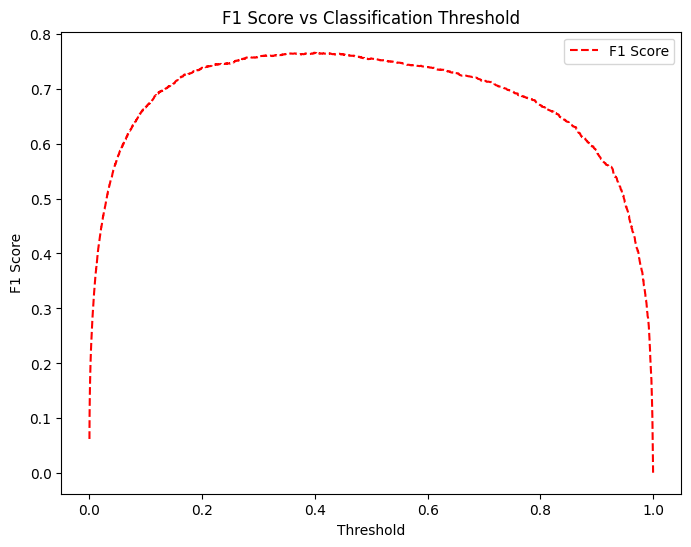

In [ ]:
# Get predicted probabilities
y_scores = log_classifier.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, y_scores)

# Compute F1-score for each threshold
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero

# Find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"Optimal threshold for highest F1-score: {best_threshold:.3f}")

# Plot the Precision-Recall curve with F1-score annotations
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", linestyle='dashed', color='red')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Classification Threshold")
plt.legend()
plt.show()


In [ ]:
# Compare F1-score before and after applying the new threshold

evaluate_model("LogReg (threshold=0.39)",
               log_classifier,
               X_train, Y_train, X_test, Y_test, cv=10, threshold=0.398)

results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)

,model,f1_train,f1_test,cv_mean_f1,cv_std
1,LogReg (threshold=0.39),0.772297,0.763739,0.76576,0.012338
0,LogReg (baseline),0.766031,0.754603,0.76576,0.012338


We see some improvement in the F1 score using the optimal threshold.

In [ ]:
# Check feature importance

feature_importance = abs(log_classifier.coef_[0])  # Take absolute values
feature_names = preprocessor.get_feature_names_out()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
2,cat__country_Germany,3.517249
3,cat__country_UK,3.270992
4,cat__country_US,2.930481
1,num__total_pages_visited,2.549475
5,cat__new_user_1,1.682898
0,num__age,0.598589
6,cat__source_Direct,0.183963
7,cat__source_Seo,0.031904


## **Random forests**

In [ ]:
# Perform grid search
rf_classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    "max_depth": [4, 6],
    "min_samples_leaf": [50, 500],
    "min_samples_split": [50, 500],
    "n_estimators": [20, 50],
}

gridsearchRF = GridSearchCV(
    rf_classifier,
    param_grid=params,
    cv=3,
    scoring=make_scorer(f1_score)
)

gridsearchRF.fit(X_train, Y_train)

print("Best hyperparameters : ", gridsearchRF.best_params_)
print("Best validation accuracy : ", gridsearchRF.best_score_)


Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 50}
Best validation accuracy :  0.9853556117787616


In [ ]:
best_rf = gridsearchRF.best_estimator_ # pass the best fitted model

In [ ]:
# Print scores
evaluate_model("Random Forest (GridSearch)",
               best_rf,
               X_train, Y_train, X_test, Y_test, cv=5)

results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)

,model,f1_train,f1_test,cv_mean_f1,cv_std
1,LogReg (threshold=0.39),0.772297,0.763739,0.765760,0.012338
0,LogReg (baseline),0.766031,0.754603,0.765760,0.012338
2,Random Forest (GridSearch),0.745270,0.727044,0.737789,0.003621


## **Other Models : SGD and MLP Classifiers**

In [ ]:
# SGD: regularized linear models with stochastic gradient descent (SGD)
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)

# Print scores
evaluate_model("SGD Classifier",
               sgd,
               X_train, Y_train, X_test, Y_test, cv=5)

results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)

,model,f1_train,f1_test,cv_mean_f1,cv_std
1,LogReg (threshold=0.39),0.772297,0.763739,0.765760,0.012338
0,LogReg (baseline),0.766031,0.754603,0.765760,0.012338
3,SGD Classifier,0.750336,0.740811,0.755904,0.010932
2,Random Forest (GridSearch),0.745270,0.727044,0.737789,0.003621


In [ ]:
# MLP : Multi-layer percepton
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, Y_train)

# Print scores
evaluate_model("MLP Classifier",
               mlp,
               X_train, Y_train, X_test, Y_test, cv=5)

results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)

,model,f1_train,f1_test,cv_mean_f1,cv_std
1,LogReg (threshold=0.39),0.772297,0.763739,0.765760,0.012338
0,LogReg (baseline),0.766031,0.754603,0.765760,0.012338
4,MLP Classifier,0.758121,0.746757,0.757507,0.006585
3,SGD Classifier,0.750336,0.740811,0.755904,0.010932
2,Random Forest (GridSearch),0.745270,0.727044,0.737789,0.003621


## **Ensemble: XGBoost**

In [ ]:
# Perform grid search
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    "max_depth": [5, 10, 20],
    "min_child_weight": [50, 80],
    "n_estimators": [20, 30],
}

gridsearchXGB = GridSearchCV(
    xgboost, param_grid=params, cv=5, scoring='f1'
)

gridsearchXGB.fit(X_train, Y_train)

best_xgb = gridsearchRF.best_estimator_ # pass the best fitted model

# Print scores
evaluate_model("XGBoost (GridSearch)",
               best_xgb,
               X_train, Y_train, X_test, Y_test, cv=5)

results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)

,model,f1_train,f1_test,cv_mean_f1,cv_std
1,LogReg (threshold=0.39),0.772297,0.763739,0.765760,0.012338
0,LogReg (baseline),0.766031,0.754603,0.765760,0.012338
4,MLP Classifier,0.758121,0.746757,0.757507,0.006585
3,SGD Classifier,0.750336,0.740811,0.755904,0.010932
5,XGBoost (GridSearch),0.745073,0.732849,0.743178,0.004688
2,Random Forest (GridSearch),0.745270,0.727044,0.737789,0.003621


## **Final Model**

Train the two best models (baseline logistic regression and MLP) and use  voting  + threshold optimization to boost model performance

In [ ]:
# === 1. Base models ===
log_reg = LogisticRegression(max_iter=1000, random_state=42)
bagging_log_reg = BaggingClassifier(estimator=log_reg, n_estimators=10, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)

# === 2. VotingClassifier (soft voting = average probabilities) ===
voting_clf = VotingClassifier(
    estimators=[
        ('bagging_log_reg', bagging_log_reg),
        ('mlp', mlp)
    ],
    voting='soft',
    n_jobs=-1
)

# === 3. Train ===
voting_clf.fit(X_train, Y_train)

# === 4. Predict with best threshold (optimize F1)
probs = voting_clf.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.1, 0.9, 81)
best_t, best_f1 = max(
    ((t, f1_score(Y_test, (probs >= t).astype(int))) for t in thresholds),
    key=lambda x: x[1]
)
y_pred = (probs >= best_t).astype(int)

# === 5. Evaluate
print(f"Best threshold: {best_t:.2f}")
print(f"F1-score:       {best_f1:.4f}")


Best threshold: 0.44
F1-score:       0.7641


In [ ]:
# === 6. Append result to results list manually
results.append({
    "model": "Voting (LogReg + MLP, thr opt)",
    "f1_train": f1_score(Y_train, (voting_clf.predict_proba(X_train)[:, 1] >= best_t).astype(int)),
    "f1_test": best_f1,
})

# === 7. Show updated results
results_df = pd.DataFrame(results).sort_values("f1_test", ascending=False)
display(results_df)


,model,f1_train,f1_test,cv_mean_f1,cv_std
6,"Voting (LogReg + MLP, thr opt)",0.771927,0.764058,NaN,NaN
1,LogReg (threshold=0.39),0.772297,0.763739,0.765760,0.012338
0,LogReg (baseline),0.766031,0.754603,0.765760,0.012338
4,MLP Classifier,0.758121,0.746757,0.757507,0.006585
3,SGD Classifier,0.750336,0.740811,0.755904,0.010932
5,XGBoost (GridSearch),0.745073,0.732849,0.743178,0.004688
2,Random Forest (GridSearch),0.745270,0.727044,0.737789,0.003621


Confusion matrix of the final model

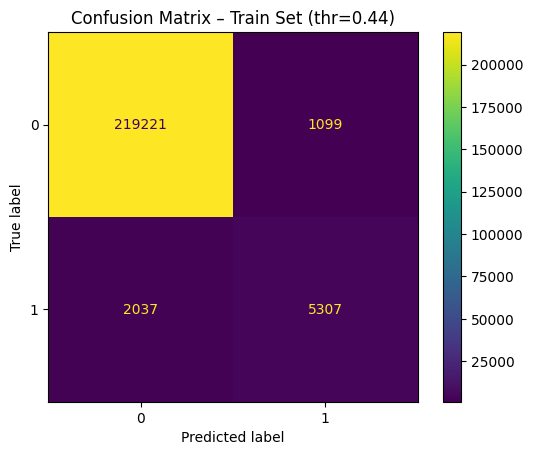

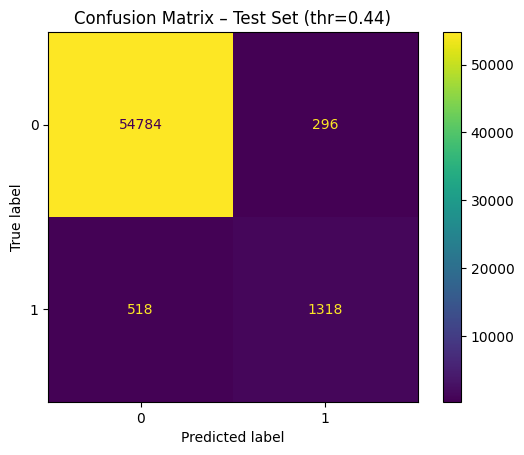

In [ ]:
# === Predict again using best threshold ===
train_probs = voting_clf.predict_proba(X_train)[:, 1]
test_probs = voting_clf.predict_proba(X_test)[:, 1]

y_train_pred = (train_probs >= best_t).astype(int)
y_test_pred  = (test_probs  >= best_t).astype(int)

# === Plot Confusion Matrix: Train ===
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    Y_train, y_train_pred, ax=ax, normalize=None
)
ax.set_title("Confusion Matrix – Train Set (thr={:.2f})".format(best_t))
plt.show()

# === Plot Confusion Matrix: Test ===
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    Y_test, y_test_pred, ax=ax, normalize=None
)
ax.set_title("Confusion Matrix – Test Set (thr={:.2f})".format(best_t))
plt.show()

**Key insights:**

- The model is very good at identifying non-converters (true negatives high).

- We have a decent recall for converters (TP = 1,318), with relatively few false negatives.

- The threshold of 0.44 seems to strike a good balance between:

-> Reducing false positives

-> Keeping recall and precision reasonable

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

voting_clf.fit(X,Y)

VotingClassifier(estimators=[('bagging_log_reg',
                              BaggingClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                             random_state=42),
                                                random_state=42)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(64, 32),
                                            max_iter=500, random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to arrays before using scikit-learn
#print("Convert pandas DataFrames to arrays...")
#X_without_labels = X_without_labels.values
#print("...Done")

#print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)


In [ ]:
X_without_labels

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [ ]:
## Pre-processing

print("Encoding categorical features and standardizing numerical features...")

X_without_labels['new_user'] = X_without_labels['new_user'].astype(object)

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])


Encoding categorical features and standardizing numerical features...
...Done
[[-0.31132378  3.3285935   0.          1.          0.          0.
   0.          1.        ]
 [-1.03650686  0.03743241  0.          1.          0.          1.
   1.          0.        ]
 [ 0.1721316  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.1721316   0.33662888  0.          0.          1.          1.
   0.          0.        ]
 [-0.67391532 -0.56096051  0.          0.          0.          0.
   0.          1.        ]]


In [ ]:
# Predict probability scores on new (unlabeled) data
y_scores_unlabeled = voting_clf.predict_proba(X_without_labels)[:, 1]

# Apply the optimal threshold for classification
y_pred_unlabeled = (y_scores_unlabeled >= best_t).astype(int)

# Export predictions
Y_predictions = pd.DataFrame({"converted": y_pred_unlabeled})
Y_predictions.to_csv("conversion_data_test_predictions_SoniaH-model-Voting-LogReg-MLP.csv", index=False)